In [1]:
import pandas as pd
import numpy as np
import random
import copy
import torch

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42

In [3]:
data = pd.read_csv('../../GeneralData/ETTh1.csv')
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [4]:
import torch.nn as nn

In [5]:
feature_size = 7

In [6]:
# LSTM은 Encoder와 Decoder를 각각 구현해야 한다.
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 14
        self.input_size = feature_size
        self.encoder = nn.LSTM(input_size = self.input_size,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       batch_first = True).to(device)
        # batch_first = True로 인해서 (batch,seq,feature)순으로 입력 받는다.
        # 그 당시에 알고 있는 정보가 없으므로 input_size = 0
        self.decoder = nn.LSTM(input_size = self.input_size,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       batch_first = True).to(device)
        
        
        self.output_layer = nn.Linear(self.hidden_size, 1).to(device)
    def forward(self,x):
        x = x.to(device)
        self.encoder.flatten_parameters()
        self.decoder.flatten_parameters()
        outputs,(hidden,cell) = self.encoder(x)
        
        # 현재 prediction_length = 1이기 때문에, 반복문을 돌리지 않아도 됨
        # but 길어진다면 반복문을 돌려서 output값을 얻어야 한다.
        # 기본적으로 output = hidden state이기에 output을 생성할
        # Fully Connected Layer가 필요하게 된다.
        # 이때 decoder_output의 사이즈는 (batch,seq,hidden) 이다
        # 중간에 seq가 들어오게 되는 이유는 입력 크기 만큼 lstm이 반복되기 때문에
        # seq=1 이기 때문에 squeeze를 수행
        
        hidden = hidden.to(device)
        cell = cell.to(device)
        decoder_input = torch.zeros([x.size(0),1,x.size(2)]).to(device)
        decoder_out,(hidden,cell) = self.decoder(decoder_input,(hidden,cell))
        decoder_out = decoder_out.squeeze(1)
        
        out = self.output_layer(decoder_out)
        
        return out

In [7]:
a = np.array([1,2,3])
a.shape[0]

3

In [8]:
lst = [i for i in range(1,13)]
A = torch.FloatTensor(lst).view(3,2,2)
B = torch.zeros((2,2))
B[0,0] = 1
B[1,1] = 1
A*B # BroadCasting

tensor([[[ 1.,  0.],
         [ 0.,  4.]],

        [[ 5.,  0.],
         [ 0.,  8.]],

        [[ 9.,  0.],
         [ 0., 12.]]])

In [9]:
class Filter(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = LSTM()
    def forward(self,x,train_index_matrix=[]):
        # 2차원 인덱스 리스트가 들어온다.
        # train_index_matrix = 2차원
        # 행은 time 열은 Feature를 의미
        if len(train_index_matrix)==0:
            return self.model(x)
        filters = torch.FloatTensor(np.full((x.shape[1],x.shape[2]),-np.inf))
        filters = filters.to(device)
        for i in range(len(train_index_matrix)):
            for train_idx in train_index_matrix[i]:
                filters[train_idx,i] = 1
        x = x*filters
        out = self.model(x)
        return out

In [10]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch

In [11]:
device = torch.device("cuda:0")

In [12]:
sequence_length = 168 # 24*7 1주일
pred_length = 1 # 1시간
split = int(len(data)*0.8)

In [13]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(0,len(x)-sequence_length):
        # 시간데이터를 제외하고 추출
        seq_list.append(x.iloc[i:i+sequence_length,1:].values)
        # OT만 추출
        target_list.append(x.iloc[i+sequence_length,-1])
        
    return torch.FloatTensor(seq_list).view(-1,sequence_length,7).to(device), torch.FloatTensor(target_list).view(-1,pred_len,1).to(device)

In [14]:
train = data.iloc[:split]
val = data.iloc[split:]

X_train, y_train = seq_data(train,sequence_length,pred_length)
X_val, y_val = seq_data(val,sequence_length,pred_length)

tr_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val,y_val)

training =  DataLoader(tr_dataset,batch_size = 64)
validation = DataLoader(val_dataset,batch_size = 64)

/tmp/ipykernel_1368970/2507691695.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.FloatTensor(seq_list).view(-1,sequence_length,7).to(device), torch.FloatTensor(target_list).view(-1,pred_len,1).to(device)


In [15]:
torch.cuda.is_available()

True

In [16]:
X_train.size() # 168개의 sequence_length 7개의 Feature

torch.Size([13768, 168, 7])

* 잘 데이터가 구성된 걸 확인 가능

In [17]:
train.iloc[:169]

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
164,2016-07-07 20:00:00,11.119,4.153,7.427,1.919,3.746,1.675,32.922001
165,2016-07-07 21:00:00,10.449,3.282,7.107,1.279,3.594,1.706,33.625999
166,2016-07-07 22:00:00,10.516,3.885,7.356,1.599,3.168,1.675,32.640999
167,2016-07-07 23:00:00,11.855,5.358,8.884,3.198,3.076,1.553,31.586000


In [18]:
X_train

tensor([[[  5.8270,   2.0090,   1.5990,  ...,   4.2030,   1.3400,  30.5310],
         [  5.6930,   2.0760,   1.4920,  ...,   4.1420,   1.3710,  27.7870],
         [  5.1570,   1.7410,   1.2790,  ...,   3.7770,   1.2180,  27.7870],
         ...,
         [ 10.4490,   3.2820,   7.1070,  ...,   3.5940,   1.7060,  33.6260],
         [ 10.5160,   3.8850,   7.3560,  ...,   3.1680,   1.6750,  32.6410],
         [ 11.8550,   5.3580,   8.8840,  ...,   3.0760,   1.5530,  31.5860]],

        [[  5.6930,   2.0760,   1.4920,  ...,   4.1420,   1.3710,  27.7870],
         [  5.1570,   1.7410,   1.2790,  ...,   3.7770,   1.2180,  27.7870],
         [  5.0900,   1.9420,   1.2790,  ...,   3.8070,   1.2790,  25.0440],
         ...,
         [ 10.5160,   3.8850,   7.3560,  ...,   3.1680,   1.6750,  32.6410],
         [ 11.8550,   5.3580,   8.8840,  ...,   3.0760,   1.5530,  31.5860],
         [ 11.8550,   4.7560,   8.8840,  ...,   2.9550,   1.5230,  31.0930]],

        [[  5.1570,   1.7410,   1.2790,  ...

In [19]:
y_train

tensor([[[31.0930]],

        [[30.7420]],

        [[29.3350]],

        ...,

        [[ 4.2910]],

        [[ 6.2610]],

        [[ 3.9390]]], device='cuda:0')

In [20]:
from torch.optim import Adam

In [21]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
model = Filter().to(device)
optimizer = Adam(model.parameters(),lr = 1e-4)
num_epochs = 200
n = len(training)

In [22]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

In [23]:
model.named_parameters

<bound method Module.named_parameters of Filter(
  (model): LSTM(
    (encoder): LSTM(7, 14, batch_first=True)
    (decoder): LSTM(7, 14, batch_first=True)
    (output_layer): Linear(in_features=14, out_features=1, bias=True)
  )
)>

In [24]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
#         print(outputs.size())
        outputs = outputs.view(-1,1)    
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[200] running accumulative loss across all batches: 299.998
changed
Epoch [2]/[200] running accumulative loss across all batches: 293.345
changed
Epoch [3]/[200] running accumulative loss across all batches: 283.591
changed
Epoch [4]/[200] running accumulative loss across all batches: 271.459
changed
Epoch [5]/[200] running accumulative loss across all batches: 258.352
changed
Epoch [6]/[200] running accumulative loss across all batches: 245.469
changed
Epoch [7]/[200] running accumulative loss across all batches: 234.679
changed
Epoch [8]/[200] running accumulative loss across all batches: 225.510
changed
Epoch [9]/[200] running accumulative loss across all batches: 217.436
changed
Epoch [10]/[200] running accumulative loss across all batches: 210.248
changed
Epoch [11]/[200] running accumulative loss across all batches: 203.722
changed
Epoch [12]/[200] running accumulative loss across all batches: 197.630
changed
Epoch [13]/[200] running accumulative loss across all batches

Epoch [106]/[200] running accumulative loss across all batches: 23.435
changed
Epoch [107]/[200] running accumulative loss across all batches: 23.049
changed
Epoch [108]/[200] running accumulative loss across all batches: 22.671
changed
Epoch [109]/[200] running accumulative loss across all batches: 22.301
changed
Epoch [110]/[200] running accumulative loss across all batches: 21.940
changed
Epoch [111]/[200] running accumulative loss across all batches: 21.586
changed
Epoch [112]/[200] running accumulative loss across all batches: 21.239
changed
Epoch [113]/[200] running accumulative loss across all batches: 20.900
changed
Epoch [114]/[200] running accumulative loss across all batches: 20.567
changed
Epoch [115]/[200] running accumulative loss across all batches: 20.242
changed
Epoch [116]/[200] running accumulative loss across all batches: 19.922
changed
Epoch [117]/[200] running accumulative loss across all batches: 19.610
changed
Epoch [118]/[200] running accumulative loss across a

In [25]:
from captum.attr import IntegratedGradients,NoiseTunnel

In [26]:
for val in validation:
    print(val[0].size())

torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])


In [27]:
test = next(iter(validation))[0][0] # 하나의 sample에 대해서 진행
test = test.unsqueeze(0)
test.size()

torch.Size([1, 168, 7])

In [28]:
ig = IntegratedGradients(model)
attr_score = ig.attribute(test,return_convergence_delta=True)
attr_score

(tensor([[[ 7.2795e-06,  6.1833e-06,  1.0780e-07,  ..., -8.7178e-06,
            5.8044e-06, -1.7340e-05],
          [ 5.9985e-06,  4.8340e-06,  6.0547e-06,  ..., -1.2217e-05,
            1.6179e-06, -1.0400e-05],
          [ 3.3266e-06,  3.7779e-06,  7.9729e-06,  ..., -1.2421e-05,
            1.5212e-06, -9.2704e-06],
          ...,
          [-1.5672e-01, -5.6650e-02,  8.3364e-01,  ..., -3.1919e-01,
           -3.0626e-02,  3.0587e-02],
          [ 5.0480e-02, -2.3200e-01,  1.0255e+00,  ..., -1.4223e-01,
           -1.1559e-02,  3.4585e-01],
          [ 7.5000e-01, -2.4765e-01, -1.1786e+00,  ...,  4.9105e-01,
           -9.7863e-02,  3.5517e+00]]], device='cuda:0', dtype=torch.float64),
 tensor([-4.2184e-07], device='cuda:0', dtype=torch.float64))

In [29]:
attr_score[0].size()

torch.Size([1, 168, 7])

In [30]:
delta = attr_score[1]

In [31]:
attr_score = attr_score[0]

In [32]:
attr_score.to("cpu")

tensor([[[ 7.2795e-06,  6.1833e-06,  1.0780e-07,  ..., -8.7178e-06,
           5.8044e-06, -1.7340e-05],
         [ 5.9985e-06,  4.8340e-06,  6.0547e-06,  ..., -1.2217e-05,
           1.6179e-06, -1.0400e-05],
         [ 3.3266e-06,  3.7779e-06,  7.9729e-06,  ..., -1.2421e-05,
           1.5212e-06, -9.2704e-06],
         ...,
         [-1.5672e-01, -5.6650e-02,  8.3364e-01,  ..., -3.1919e-01,
          -3.0626e-02,  3.0587e-02],
         [ 5.0480e-02, -2.3200e-01,  1.0255e+00,  ..., -1.4223e-01,
          -1.1559e-02,  3.4585e-01],
         [ 7.5000e-01, -2.4765e-01, -1.1786e+00,  ...,  4.9105e-01,
          -9.7863e-02,  3.5517e+00]]], dtype=torch.float64)

In [33]:
plot_attribution = attr_score.to("cpu").detach().numpy()
plot_attribution

array([[[ 7.27946294e-06,  6.18329540e-06,  1.07804897e-07, ...,
         -8.71778966e-06,  5.80435712e-06, -1.73397251e-05],
        [ 5.99845781e-06,  4.83401888e-06,  6.05473321e-06, ...,
         -1.22168449e-05,  1.61786184e-06, -1.04004627e-05],
        [ 3.32659169e-06,  3.77789859e-06,  7.97285480e-06, ...,
         -1.24206807e-05,  1.52124493e-06, -9.27041976e-06],
        ...,
        [-1.56718455e-01, -5.66504632e-02,  8.33642792e-01, ...,
         -3.19186644e-01, -3.06264542e-02,  3.05872281e-02],
        [ 5.04803877e-02, -2.32004522e-01,  1.02546276e+00, ...,
         -1.42230756e-01, -1.15590152e-02,  3.45846561e-01],
        [ 7.50001424e-01, -2.47650251e-01, -1.17862638e+00, ...,
          4.91045561e-01, -9.78628999e-02,  3.55169980e+00]]])

In [34]:
plot_attribution = plot_attribution.reshape(-1,7)

In [35]:
column = data.columns[1:]
column

Index(['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')

In [36]:
attr_df = pd.DataFrame(plot_attribution,columns=column)

In [37]:
attr_df

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,7.279463e-06,0.000006,1.078049e-07,0.000009,-0.000009,5.804357e-06,-0.000017
1,5.998458e-06,0.000005,6.054733e-06,0.000004,-0.000012,1.617862e-06,-0.000010
2,3.326592e-06,0.000004,7.972855e-06,0.000003,-0.000012,1.521245e-06,-0.000009
3,-2.944322e-06,0.000003,9.133870e-06,0.000002,-0.000010,-3.350724e-08,-0.000005
4,2.695831e-07,0.000004,7.546096e-06,0.000001,-0.000011,-1.448393e-07,-0.000004
...,...,...,...,...,...,...,...
163,-1.679156e-01,0.001354,6.702499e-01,-0.031586,-0.361791,-3.993744e-02,-0.066121
164,-2.417698e-01,-0.011250,8.250063e-01,-0.036049,-0.332986,-3.084385e-02,-0.047876
165,-1.567185e-01,-0.056650,8.336428e-01,-0.038598,-0.319187,-3.062645e-02,0.030587
166,5.048039e-02,-0.232005,1.025463e+00,-0.037175,-0.142231,-1.155902e-02,0.345847


# 특징 관찰

### our goal -> 특정 시간대를 추출해내는 방법을 고안

In [38]:
next(iter(validation))[1][0]

tensor([[3.4470]], device='cuda:0')

* 전체 Attribution DataFrame이 예측값을 나눈것으로 보임
    * 현재 하나의 Sample Batch의 첫번째 Sample에 대해서 Attribution을 구했는데
    하나의 DataFrame이 나왔음

In [39]:
attr_df.sum(axis=0).sum()

3.5755725456904917

1. delta가 attribution 유의미하게 작은지 확인
2. baseline vector 넣었을떄 0인지

### 1의 답

In [40]:
delta

tensor([-4.2184e-07], device='cuda:0', dtype=torch.float64)

In [41]:
test_baseline = torch.FloatTensor(np.zeros((1,sequence_length,7)))
base_pred = model(test_baseline)
base_pred

tensor([[-0.4740]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 2의 답

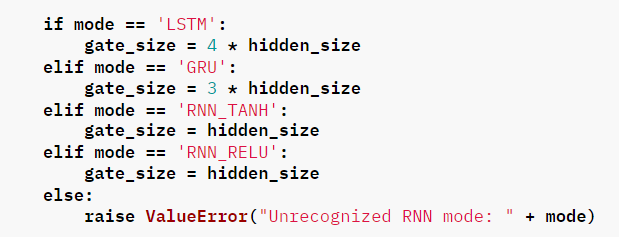
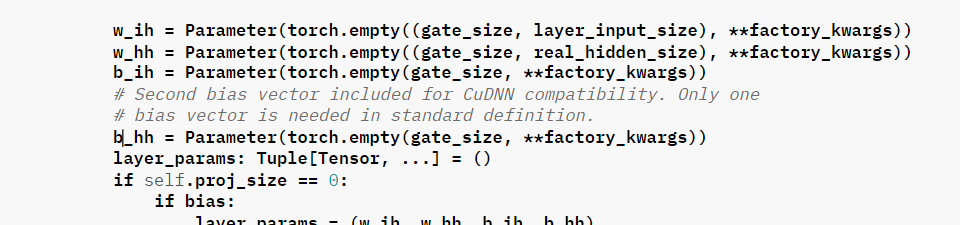

<font color = blue><font size = 5> what is CuDNN Compatibility?</font></font>

https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html

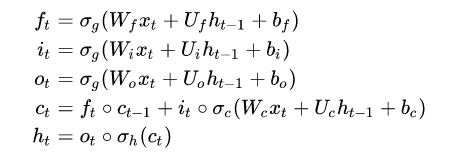

* **LSTM의 bias는 4개가 존재하고 따라서 4*hiddensize만큼의 bias element갯수가 존재한다.**

In [42]:
bias1 = model.model.encoder.bias_hh_l0
bias1

Parameter containing:
tensor([ 0.1710,  0.0439,  0.3144, -0.0021, -0.0252,  0.1300, -0.0585,  0.3216,
        -0.0514,  0.2664,  0.2211,  0.0895,  0.0987, -0.0208, -0.3302, -0.0123,
        -0.0796,  0.0348,  0.0932, -0.2107, -0.0843,  0.0701,  0.0333,  0.0098,
         0.0101,  0.0396, -0.0135, -0.2678, -0.1596,  0.2393, -0.1882, -0.2287,
         0.2262,  0.2909,  0.0064,  0.1542, -0.0166, -0.5002,  0.1158,  0.2509,
         0.0273,  0.0863, -0.0974,  0.4300,  0.3866,  0.1752,  0.4716,  0.2127,
         0.0010,  0.1220,  0.1059,  0.1752, -0.2231,  0.3103,  0.2604, -0.2521],
       device='cuda:0', requires_grad=True)

In [43]:
bias1.sum(axis=0)

tensor(3.1737, device='cuda:0', grad_fn=<SumBackward1>)

In [44]:
model.model.encoder.bias_hh_l0.size()

torch.Size([56])

In [45]:
bias2 = model.model.encoder.bias_ih_l0
bias2

Parameter containing:
tensor([ 0.2479,  0.0631,  0.3179,  0.1004,  0.0562,  0.1122, -0.3207, -0.1092,
         0.1218,  0.1716,  0.1662,  0.0992, -0.0419,  0.1239, -0.1718,  0.2307,
         0.2527, -0.1963, -0.0821, -0.1618, -0.1821, -0.0083,  0.0920, -0.3007,
        -0.0666, -0.2170, -0.1764,  0.2200, -0.3214, -0.1735,  0.0977, -0.0714,
         0.1692,  0.2431,  0.4011, -0.2023,  0.1894, -0.0124, -0.0363,  0.4103,
         0.3078, -0.0037,  0.2600,  0.1513, -0.0743,  0.0954,  0.5060, -0.0500,
         0.3240, -0.0395,  0.3614,  0.5827,  0.0471, -0.0372,  0.2091,  0.0362],
       device='cuda:0', requires_grad=True)

In [46]:
bias2.sum(axis = 0)

tensor(3.7101, device='cuda:0', grad_fn=<SumBackward1>)

* 하나의 샘플은 모두 (168,7)의 동일한 크기를 갖는다.

In [47]:
cnt = 0
ig = IntegratedGradients(model)
ig_attr_score = np.zeros((sequence_length,feature_size))
for val_batch in validation:
    temp_n = val_batch[0].size(0)
    for val in val_batch[0]: # 하나의 배치에 대해서 for문
        val = val.unsqueeze(0)
        temp = ig.attribute(val).abs()
        # 각 attribution score의 절대값을 합한다.
        # 이로써 각 시간별로 영향도를 구함
        # 이 부분이 abs를 씌우는게 절대적인 영향을 반영하는데에 맞는 것 같다.
        # 이전까진 씌우지 않았음
        temp = temp.squeeze(0)
        temp = temp.to("cpu").detach().numpy()   
        ig_attr_score = ig_attr_score+temp
    cnt = cnt + temp_n
ig_attr_score = ig_attr_score/cnt

In [48]:
data.columns[1:]

Index(['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')

In [49]:
ig_attr_score[:,0]

array([4.76296472e-06, 4.37227424e-06, 3.67684168e-06, 3.38948752e-06,
       3.31873047e-06, 3.16661574e-06, 3.01978065e-06, 2.92214858e-06,
       2.83846943e-06, 2.82128122e-06, 2.77979167e-06, 2.81113889e-06,
       2.85657559e-06, 2.92224209e-06, 3.06139821e-06, 3.16193015e-06,
       3.28450455e-06, 3.49521119e-06, 3.57089870e-06, 3.57349198e-06,
       3.58837946e-06, 3.64961783e-06, 3.75352306e-06, 3.72908750e-06,
       3.99175870e-06, 4.13159338e-06, 4.18131613e-06, 4.32523508e-06,
       4.27395780e-06, 4.29421763e-06, 4.40313688e-06, 4.43830342e-06,
       4.64844755e-06, 4.80629759e-06, 4.85356039e-06, 4.96139416e-06,
       4.92141384e-06, 4.94690549e-06, 5.04725060e-06, 5.19269045e-06,
       5.44623325e-06, 5.77012450e-06, 6.18729283e-06, 6.65483595e-06,
       7.05783540e-06, 7.52285504e-06, 7.91089454e-06, 8.12949648e-06,
       8.47820603e-06, 8.89718949e-06, 8.92877616e-06, 9.01225848e-06,
       9.22729847e-06, 9.38297712e-06, 9.50469522e-06, 9.82229882e-06,
      

In [50]:
np

<module 'numpy' from '/home/sjlee/sj_virtual/lib/python3.8/site-packages/numpy/__init__.py'>

In [51]:
sub_attr_df = []
for cnt,column in enumerate(list(data.columns[1:])):
    attr_df = pd.DataFrame(ig_attr_score[:,0],columns = [column])
    sub_attr_df.append(attr_df)
sub_attr_df

[         HUFL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 163  0.076424
 164  0.087846
 165  0.103336
 166  0.271093
 167  0.999780
 
 [168 rows x 1 columns],
          HULL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 163  0.076424
 164  0.087846
 165  0.103336
 166  0.271093
 167  0.999780
 
 [168 rows x 1 columns],
          MUFL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 163  0.076424
 164  0.087846
 165  0.103336
 166  0.271093
 167  0.999780
 
 [168 rows x 1 columns],
          MULL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 163  0.076424
 164  0.087846
 165  0.103336
 166  0.271093
 167  0.999780
 
 [168 rows x 1 columns],
          LUFL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 163  0.076424
 164  0.087846
 165  0.103336
 166  0.271093
 167  0

In [52]:
candidate_sub_attr_df = []
for attr_df in sub_attr_df:
    IQR = 1.5*(attr_df.quantile(0.75)-attr_df.quantile(0.25))
    outlier_max = attr_df.quantile(0.75)+IQR
    outlier_min = attr_df.quantile(0.25)-IQR
    candidate_attr = attr_df[(attr_df>=outlier_min) & (attr_df<=outlier_max)]
    candidate_attr = candidate_attr.dropna()
    candidate_sub_attr_df.append(candidate_attr)
candidate_sub_attr_df

[         HUFL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 130  0.000477
 131  0.000526
 132  0.000580
 133  0.000631
 134  0.000696
 
 [135 rows x 1 columns],
          HULL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 130  0.000477
 131  0.000526
 132  0.000580
 133  0.000631
 134  0.000696
 
 [135 rows x 1 columns],
          MUFL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 130  0.000477
 131  0.000526
 132  0.000580
 133  0.000631
 134  0.000696
 
 [135 rows x 1 columns],
          MULL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 130  0.000477
 131  0.000526
 132  0.000580
 133  0.000631
 134  0.000696
 
 [135 rows x 1 columns],
          LUFL
 0    0.000005
 1    0.000004
 2    0.000004
 3    0.000003
 4    0.000003
 ..        ...
 130  0.000477
 131  0.000526
 132  0.000580
 133  0.000631
 134  0

In [53]:
import matplotlib.pyplot as plt

[         attr
 0    0.002861
 1    0.002297
 2    0.001294
 3    0.000880
 4    0.000778
 ..        ...
 130  0.684154
 131  0.754501
 132  0.832512
 133  0.906671
 134  1.000000
 
 [135 rows x 1 columns],
          attr
 0    0.002861
 1    0.002297
 2    0.001294
 3    0.000880
 4    0.000778
 ..        ...
 130  0.684154
 131  0.754501
 132  0.832512
 133  0.906671
 134  1.000000
 
 [135 rows x 1 columns],
          attr
 0    0.002861
 1    0.002297
 2    0.001294
 3    0.000880
 4    0.000778
 ..        ...
 130  0.684154
 131  0.754501
 132  0.832512
 133  0.906671
 134  1.000000
 
 [135 rows x 1 columns],
          attr
 0    0.002861
 1    0.002297
 2    0.001294
 3    0.000880
 4    0.000778
 ..        ...
 130  0.684154
 131  0.754501
 132  0.832512
 133  0.906671
 134  1.000000
 
 [135 rows x 1 columns],
          attr
 0    0.002861
 1    0.002297
 2    0.001294
 3    0.000880
 4    0.000778
 ..        ...
 130  0.684154
 131  0.754501
 132  0.832512
 133  0.906671
 134  1

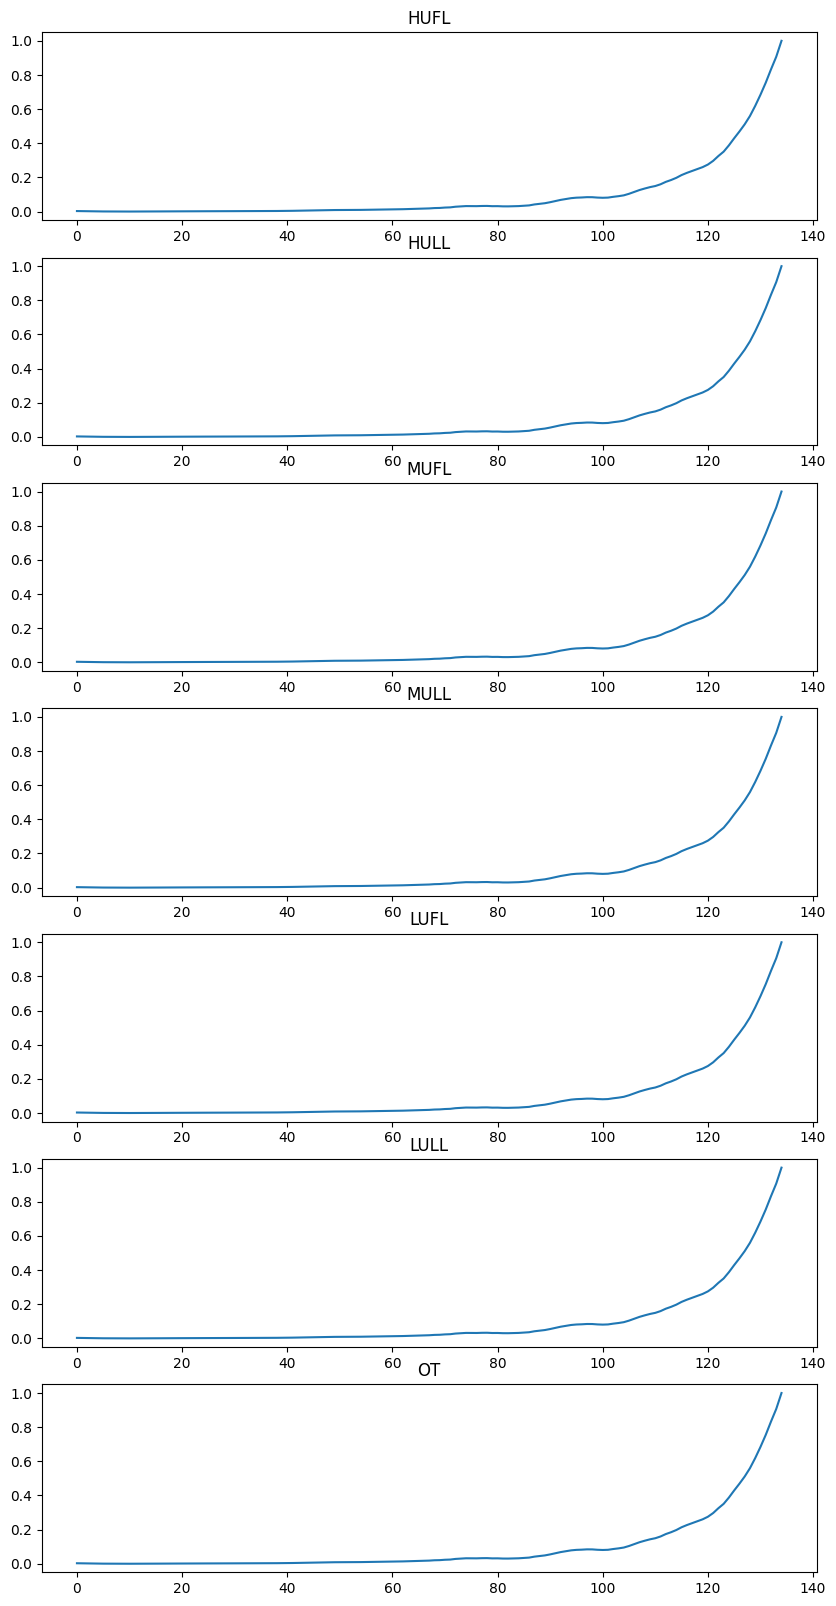

In [54]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
filtering_attr_list = [] # scaling한 attribution dataframe을 저장
fig,ax = plt.subplots(7,1,figsize = (10,20))
for cnt,candidate_attr in enumerate(candidate_sub_attr_df):
    scaler = MinMaxScaler()
    scaler.fit(candidate_attr.values)
    m_attr_df = scaler.transform(candidate_attr.values)
    m_attr_df = pd.DataFrame({"attr":m_attr_df.reshape(-1)})
    filtering_attr_list.append(m_attr_df)
    ax[cnt].plot(m_attr_df)
    ax[cnt].set_title(candidate_attr.columns.item())
filtering_attr_list

In [55]:
total_index_list = [] # train할 index를 저장해두는 리스트이다.
for hyper_para in np.arange(0.00,1.00,0.01):
    index_list = []
    # filtering index를 만든다.
    for m_attr_df in filtering_attr_list:
        append_idx = list(m_attr_df[(m_attr_df['attr']>=hyper_para)].index)
        index_list.append(append_idx)
    total_index_list.append(index_list)
len(total_index_list) 

100

In [56]:
from pytorch_forecasting.metrics import SMAPE,MAE,RMSE

In [ ]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
num_epochs = 100
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
for sub_index_list in total_index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = sub_index_list
    minimal_loss=np.inf
    model = Filter().to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs,train_idx)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

In [63]:
len(mse_out_list)

100

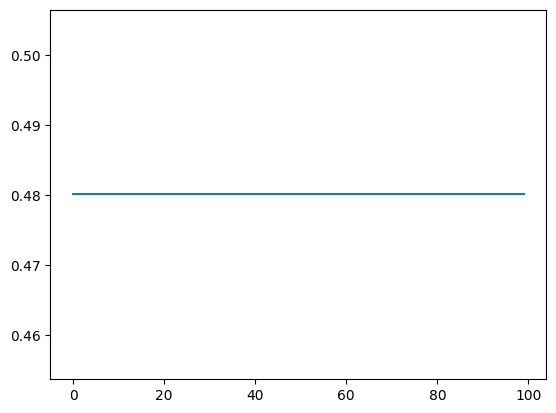

In [64]:
plt.plot(mse_out_list)

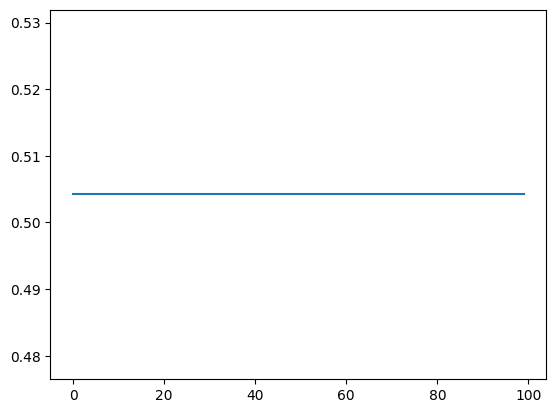

In [65]:
plt.plot(mae_out_list)

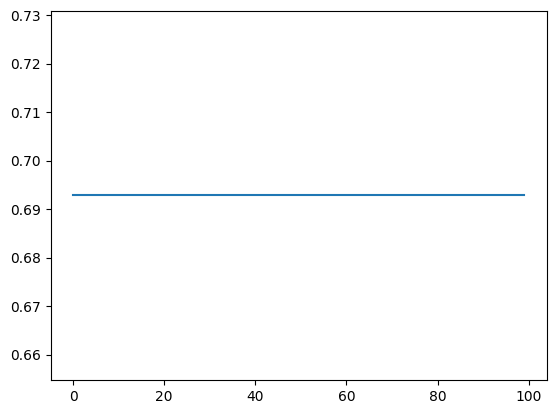

In [66]:
plt.plot(rmse_out_list)

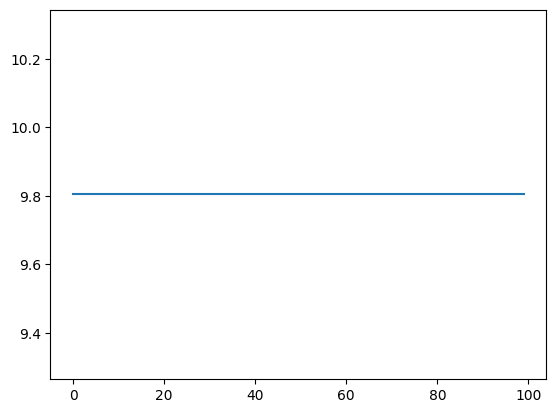

In [67]:
plt.plot(smape_out_list)